In [1]:
import tensorflow as tf
import numpy as np


import pandas as pd
import openpyxl # Needed for reading excel
import pathlib


In [2]:
# SAMPLES = 32
# TIME = 6
# FEATURES = 40
# generator = tf.random.Generator.from_seed(1)
# data = generator.normal(shape=[40, 3])
# X = generator.normal(shape=[SAMPLES, TIME, FEATURES])
# y = generator.normal(shape=[SAMPLES, 2])

In [3]:
from decomposition import Filter
class IterativeFilterCallback(tf.keras.callbacks.Callback):
    def __init__(self, windower, model_class, iterations=2, iteration=0, threshold=0.2):
        # self.train_dataset = train_dataset
        # self.iteration = iteration
        # self.iterations = iterations
        self.model_class = model_class
        self.threshold = threshold
        self.windower = windower

        if isinstance(threshold, int):
            self.k = threshold
        

    def on_train_end(self, logs={}):
        # if self.iteration >= self.iterations:
        #     return
        model = self.model

        attention_weights = []
        for x, _ in self.windower.train:
            attention_weights.append(model.get_attention_weights(x))
        
        # print(attention_weights)
        attention_weights = tf.concat(attention_weights, axis=0)
        averaged_attention_weights = tf.math.reduce_mean(tf.math.reduce_mean(attention_weights, axis=0), axis=0)
        # print(averaged_attention_weights)
        
        ######## THIS IS TEMPORARY ########
        self.threshold = tf.reduce_mean(averaged_attention_weights)
        ######## THIS IS TEMPORARY ########

        try:
            self.indices = tf.math.top_k(averaged_attention_weights, self.k, sorted=False).indices
            # print(self.indices)

        except AttributeError:
            self.mask = averaged_attention_weights >= self.threshold
            self.indices = tf.where(self.mask)

        columns = self.windower.train_df.columns[tf.reshape(self.indices, (-1,))]
        # print(columns)
        columns = list(columns) + self.windower.label_columns
        # columns = list(set(columns))
        filter = Filter(columns)
        
        filtered_windower = self.windower.copy()
        filtered_windower.preprocess(filter)
        self.filtered_windower = filtered_windower


In [4]:
#model.summary()


In [5]:

cwd = pathlib.Path.cwd()

code_directory = cwd.parents[1]

bas_directory = code_directory / "notebooks" / "Bas"
gonem_directory = code_directory / "notebooks" / "Gonem"
# data_file = bas_directory / "cadeautjevoorGonemenLiza.xlsx"
data_file = gonem_directory / "MAIZE_FILTERED_2023-02-25_19-36-41.xlsx"
data_file


df = pd.read_excel(data_file, header=[0, 1], index_col=0)
df.head(5)

AVG_TAVG                                                  \
PARTNER_Labels      Brazil      France     Germany     Hungary     Ukraine   
TIME_PERIOD                                                                  
2005-01-01      269.701032   50.081198   28.651592   -1.306452    0.869290   
2005-02-01      266.743474   30.689158   -1.962406  -25.371429  -38.376438   
2005-03-01      266.528149   76.202630   45.730051   38.383871   -3.794989   
2005-04-01      253.719444  108.081105  101.859649  112.460000   90.622214   
2005-05-01      247.859946  147.068032  134.667233  162.993548  161.493475   

               Corn Price Futures                                  ...  \
PARTNER_Labels             Brazil  France Germany Hungary Ukraine  ...   
TIME_PERIOD                                                        ...   
2005-01-01                 204.50  204.50  204.50  204.50  204.50  ...   
2005-02-01                 222.75  222.75  222.75  222.75  222.75  ...   
2005-03-01                 221.00  221.00  221.00  221.00  221.00  ...   
2005-04-01                 213.50  213.50  213.50  213.50  213.50  ...   
2005-05-01                 230.75  230.75  230.75  230.75  230.75  ...   

               renewable_energy_consumption_perc_of_total                      \
PARTNER_Labels                                     Brazil    France   Germany   
TIME_PERIOD                                                                     
2005-01-01                                         46.130  8.660000  7.280000   
2005-02-01                                         46.175  8.648333  7.389167   
2005-03-01                                         46.220  8.636667  7.498333   
2005-04-01                                         46.265  8.625000  7.607500   
2005-05-01                                         46.310  8.613333  7.716667   

                               unemployment_total                       \
PARTNER_Labels Hungary Ukraine             Brazil    France    Germany   
TIME_PERIOD                                                              
2005-01-01      7.2900    1.27          10.550000  8.880000  11.170000   
2005-02-01      7.3375    1.31          10.478333  8.875833  11.093333   
2005-03-01      7.3850    1.35          10.406667  8.871667  11.016667   
2005-04-01      7.4325    1.39          10.335000  8.867500  10.940000   
2005-05-01      7.4800    1.43          10.263333  8.863333  10.863333   

                                  
PARTNER_Labels Hungary   Ukraine  
TIME_PERIOD                       
2005-01-01       7.190  7.180000  
2005-02-01       7.215  7.149167  
2005-03-01       7.240  7.118333  
2005-04-01       7.265  7.087500  
2005-05-01       7.290  7.056667  

[5 rows x 85 columns]

In [6]:
label_columns = ['price']
label_columns = df.columns[df.columns.get_level_values(0).isin(label_columns)].tolist()
df[label_columns] = np.log(df[label_columns])
df['price'].describe()

PARTNER_Labels,Brazil,France,Germany,Hungary,Ukraine
count,214.000000,214.000000,214.000000,214.000000,214.000000
mean,-1.451613,-1.655466,-1.627641,-1.630898,-1.608843
std,0.650295,0.257695,0.281516,0.522798,0.209228
min,-2.140174,-2.173678,-2.216087,-2.278537,-2.134595
25%,-1.827919,-1.829951,-1.810592,-1.988464,-1.756903
50%,-1.709646,-1.659015,-1.601835,-1.720488,-1.638592
75%,-1.440921,-1.526392,-1.485594,-1.526783,-1.493254
max,1.609438,-0.817254,0.112323,0.306396,-0.958786


In [7]:
from decomposition import STLDecomposer

label_columns = ['price']
label_columns = df.columns[df.columns.get_level_values(0).isin(label_columns)].tolist()


stl_preprocessor = STLDecomposer(labels=label_columns, period=12)

# data = dc(df)
# data.head(5)

In [8]:
from windower import WindowGenerator

width = 12
label_width = 3
shift = 3

w = WindowGenerator(input_width=width, label_width=label_width, shift=shift, data=df, 
                    split=[0, 0.6, 0.85, 1], remove_labels=True)
w.preprocess(stl_preprocessor)
w

Total window size: 15
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11]
Label indices: [12 13 14]
Label column name(s): None

In [9]:
w.train

<MapDataset element_spec=(TensorSpec(shape=(None, 12, 100), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3, 100), dtype=tf.float32, name=None))>

In [10]:
df = w.train_df
label_columns = ['price']
label_columns = df.columns[df.columns.get_level_values(0).isin(label_columns)].tolist()
# label_columns = [('price', 'France')]
w.set_label_columns(label_columns)

In [11]:
# print(len(w.train_df.columns))
# w.train_df.columns

In [12]:
for example_inputs, example_labels in w.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 12, 95)
Labels shape (batch, time, features): (32, 3, 5)


In [13]:
# for example_inputs, example_labels in w.train.take(1):
#     print(f'Inputs (batch, time, features): {example_inputs[1]}')
#     print(f'Labels (batch, time, features): {example_labels[1]}')

In [14]:
w.label_columns

[('price', 'Brazil'),
 ('price', 'France'),
 ('price', 'Germany'),
 ('price', 'Hungary'),
 ('price', 'Ukraine')]

In [17]:
from model import AutoregressiveFeedback, EncoderDecoder, SingleShot
len(label_columns)
# m = AutoregressiveFeedback(out_steps=label_width, number_of_features=5, units=128, num_layers=5, heads=8, dropout=0.2)
# m = EncoderDecoder(out_steps=label_width, number_of_features=5, units=128, num_layers=5, heads=8, dropout=0.2)
m = SingleShot(out_steps=label_width, number_of_features=5, units=128, num_layers=5, heads=8, dropout=0.2)
m.compile(
    loss='mse', 
    metrics=['mae', 'mse', 'mape'],
    run_eagerly=True,
    )

filter_callback = IterativeFilterCallback(w, model_class=AutoregressiveFeedback, iterations=1, threshold=85)
m.fit(w.train, batch_size=32, epochs=5, validation_data=w.val)#, callbacks=[filter_callback])

Epoch 1/5
4/4 [==============================] - 3s 368ms/step - loss: 7.4326 - mae: 2.1111 - mse: 7.4326 - mape: 130.5225 - val_loss: 2.1314 - val_mae: 1.4182 - val_mse: 2.1314 - val_mape: 88.2816
Epoch 2/5
4/4 [==============================] - 1s 364ms/step - loss: 2.0512 - mae: 1.3753 - mse: 2.0512 - mape: 81.7379 - val_loss: 0.8961 - val_mae: 0.8931 - val_mse: 0.8961 - val_mape: 60.7061
Epoch 3/5
4/4 [==============================] - 1s 368ms/step - loss: 1.1151 - mae: 0.8821 - mse: 1.1151 - mape: 55.3690 - val_loss: 0.2864 - val_mae: 0.3974 - val_mse: 0.2864 - val_mape: 41.1719
Epoch 4/5
4/4 [==============================] - 1s 363ms/step - loss: 0.9505 - mae: 0.7722 - mse: 0.9505 - mape: 49.2306 - val_loss: 0.3207 - val_mae: 0.4787 - val_mse: 0.3207 - val_mape: 43.9043
Epoch 5/5
4/4 [==============================] - 1s 324ms/step - loss: 0.9780 - mae: 0.8002 - mse: 0.9780 - mape: 50.7796 - val_loss: 0.3473 - val_mae: 0.5117 - val_mse: 0.3473 - val_mape: 45.1989


In [24]:
import sys
!{sys.executable} -m pip install keras-tuner
import keras_tuner

In [25]:
def build_ARF(hp):
    lstm_units = hp.Int("lstm_units", min_value=32, max_value=512, step=32)
    lstm_layers = hp.Int("lstm_layers", min_value=0, max_value=10)
    prediction_units = hp.Int("prediction_units", min_value=32, max_value=512, step=32)
    prediction_layers = hp.Int("prediction_layers", min_value=0, max_value=10)
    feature_units = hp.Int("feature_units", min_value=32, max_value=512, step=32)
    feature_layers = hp.Int("feature_layers", min_value=0, max_value=10)
    
    heads = hp.Int("heads", min_value=1, max_value=16)
    dropout = hp.Float("dropout", min_value=0, max_value=1)
    key_dim = hp.Int('key_dim', min_value=16, max_value=128, step=16)

    model = AutoregressiveFeedback(out_steps=label_width, number_of_features=5, lstm_units=lstm_units, lstm_layers=lstm_layers,
                                   prediction_units=prediction_units, prediction_layers=prediction_layers, feature_units=feature_units,
                                   feature_layers=feature_layers, key_dim=key_dim, heads=heads, dropout=dropout)
    learning_rate = hp.Float("learning_rate", min_value=1e-7, max_value=1e-2, sampling="log")
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='mse', 
        metrics=['mae', 'mse', 'mape']
        )

    return model

In [26]:
def build_SS(hp):
    lstm_units = hp.Int("lstm_units", min_value=32, max_value=512, step=32)
    lstm_layers = hp.Int("lstm_layers", min_value=0, max_value=10)
    dense_units = hp.Int("dense_units", min_value=32, max_value=512, step=32)
    dense_layers = hp.Int("dense_layers", min_value=0, max_value=10)
    

    heads = hp.Int("heads", min_value=1, max_value=16)
    dropout = hp.Float("dropout", min_value=0, max_value=1)
    key_dim = hp.Int('key_dim', min_value=16, max_value=128, step=16)

    # m = EncoderDecoder(out_steps=label_width, number_of_features=5, units=units, blocks=blocks, heads=heads, dropout=dropout)
    model = SingleShot(out_steps=label_width, number_of_features=5, lstm_units=lstm_units, lstm_layers=lstm_layers, dense_units=dense_units, dense_layers=dense_layers, key_dim=key_dim, heads=heads, dropout=dropout)

    learning_rate = hp.Float("learning_rate", min_value=1e-7, max_value=1e-2, sampling="log")
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='mse', 
        metrics=['mae', 'mse', 'mape']
        )

    return model

In [27]:
def build_ED(hp):
    encoder_units = hp.Int("encoder_units", min_value=32, max_value=512, step=32)
    encoder_layers = hp.Int("encoder_layers", min_value=0, max_value=10)
    decoder_units = hp.Int("decoder_units", min_value=32, max_value=512, step=32)
    decoder_layers = hp.Int("decoder_layers", min_value=0, max_value=10)
    dense_units = hp.Int("dense_units", min_value=32, max_value=512, step=32)
    dense_layers = hp.Int("dense_layers", min_value=0, max_value=10)

    heads = hp.Int("heads", min_value=1, max_value=16)
    dropout = hp.Float("dropout", min_value=0, max_value=1)
    key_dim = hp.Int('key_dim', min_value=16, max_value=128, step=16)

    model = EncoderDecoder(out_steps=label_width, number_of_features=5, encoder_units=encoder_units, encoder_layers=encoder_layers,
                           decoder_units=decoder_units, decoder_layers=decoder_layers, dense_units=dense_units,
                           dense_layers=dense_layers, key_dim=key_dim, heads=heads, dropout=dropout)

    learning_rate = hp.Float("learning_rate", min_value=1e-7, max_value=1e-2, sampling="log")
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='mse', 
        metrics=['mae', 'mse', 'mape']
        )

    return model

In [32]:

tuner_arf = keras_tuner.Hyperband(
    hypermodel=build_ARF,
    objective="val_mse",
    max_epochs=200,
    factor=3,
    hyperband_iterations=1,
    executions_per_trial=5,
    seed=2023,
    max_retries_per_trial=10,
    max_consecutive_failed_trials=10,
    overwrite=False,
    directory=gonem_directory/'hp',
    project_name="ARF",
)

In [33]:
tuner_ss = keras_tuner.Hyperband(
    hypermodel=build_SS,
    objective="val_mse",
    max_epochs=200,
    factor=3,
    hyperband_iterations=1,
    executions_per_trial=5,
    seed=2023,
    overwrite=False,
    directory=gonem_directory/'hp',
    project_name="SS",
)

In [34]:
tuner_ed = keras_tuner.Hyperband(
    hypermodel=build_ED,
    objective="val_mse",
    max_epochs=200,
    factor=3,
    hyperband_iterations=1,
    executions_per_trial=5,
    seed=2023,
    overwrite=False,
    directory=gonem_directory/'hp',
    project_name="ED",
)

In [35]:
tuner_arf.search(w.train, validation_data=w.val, verbose=2)


Trial 2 Complete [00h 00m 01s]

Best val_mse So Far: 0.35060474276542664
Total elapsed time: 00h 00m 59s

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
256               |224               |lstm_units
10                |5                 |lstm_layers
480               |288               |prediction_units
6                 |1                 |prediction_layers
352               |64                |feature_units
3                 |3                 |feature_layers
9                 |12                |heads
0.59201           |0.28575           |dropout
32                |96                |key_dim
0.0054359         |0.0013766         |learning_rate
3                 |3                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
4                 |4                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/3
4/4 - 18s - loss: 3.6776 - mae: 1.7150 - mse: 3.6776 - mape: 104.1065 - val_loss: 1.6784 -

In [44]:
m = tuner_arf.get_best_models(num_models=1)[0]

In [ ]:
tuner_ss.search(w.train, epochs=1000, validation_data=w.val, verbose=2)


In [ ]:
tuner_ed.search(w.train, epochs=1000, validation_data=w.val, verbose=2)


In [66]:
for example_inputs, example_labels in filter_callback.filtered_windower.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

AttributeError: 'IterativeFilterCallback' object has no attribute 'filtered_windower'

In [ ]:
print(filter_callback.filtered_windower.train_df.columns)
filter_callback.filtered_windower.train_df.sort_index(axis=1).head(4)

MultiIndex([(  'energy_use_kg_of_oil_equivalent_per_capita',  'France'),
            ('fossil_fuel_energy_consumption_perc_of_total', 'Hungary'),
            (                                 'price_trend',  'Brazil'),
            (                              'price_seasonal',  'Brazil'),
            (                              'price_residual',  'Brazil'),
            (                                 'price_trend',  'France'),
            (                              'price_seasonal',  'France'),
            (                              'price_residual',  'France'),
            (                                 'price_trend', 'Germany'),
            (                              'price_seasonal', 'Germany'),
            (                              'price_residual', 'Germany'),
            (                                 'price_trend', 'Hungary'),
            (                              'price_seasonal', 'Hungary'),
            (                              'price_r

AVG_TAVG                                      \
                         Brazil      France     Germany     Hungary   
TIME_PERIOD                                                           
2005-01-01 00:00:00  269.701032   50.081198   28.651592   -1.306452   
2005-02-01 00:00:00  266.743474   30.689158   -1.962406  -25.371429   
2005-03-01 00:00:00  266.528149   76.202630   45.730051   38.383871   
2005-04-01 00:00:00  253.719444  108.081105  101.859649  112.460000   

                               Corn Price Futures                          \
                       Ukraine             Brazil  France Germany Hungary   
TIME_PERIOD                                                                 
2005-01-01 00:00:00   0.869290               0.00    0.00    0.00    0.00   
2005-02-01 00:00:00 -38.376438             222.75  222.75  222.75  222.75   
2005-03-01 00:00:00  -3.794989             221.00  221.00  221.00  221.00   
2005-04-01 00:00:00  90.622214             213.50  213.50  213.50  213.50   

                             ... renewable_energy_consumption_perc_of_total  \
                    Ukraine  ...                                     Brazil   
TIME_PERIOD                  ...                                              
2005-01-01 00:00:00    0.00  ...                                     46.130   
2005-02-01 00:00:00  222.75  ...                                     46.175   
2005-03-01 00:00:00  221.00  ...                                     46.220   
2005-04-01 00:00:00  213.50  ...                                     46.265   

                                                        unemployment_total  \
                       France   Germany Hungary Ukraine             Brazil   
TIME_PERIOD                                                                  
2005-01-01 00:00:00  8.660000  7.280000  7.2900    1.27          10.550000   
2005-02-01 00:00:00  8.648333  7.389167  7.3375    1.31          10.478333   
2005-03-01 00:00:00  8.636667  7.498333  7.3850    1.35          10.406667   
2005-04-01 00:00:00  8.625000  7.607500  7.4325    1.39          10.335000   

                                                            
                       France    Germany Hungary   Ukraine  
TIME_PERIOD                                                 
2005-01-01 00:00:00  8.880000  11.170000   7.190  7.180000  
2005-02-01 00:00:00  8.875833  11.093333   7.215  7.149167  
2005-03-01 00:00:00  8.871667  11.016667   7.240  7.118333  
2005-04-01 00:00:00  8.867500  10.940000   7.265  7.087500  

[4 rows x 90 columns]

In [20]:
filter_callback.threshold

<tf.Tensor: shape=(), dtype=float32, numpy=0.011764705>

In [21]:
w.label_columns

[('price', 'Brazil'),
 ('price', 'France'),
 ('price', 'Germany'),
 ('price', 'Hungary'),
 ('price', 'Ukraine')]

In [22]:
w = filter_callback.filtered_windower
w.train

<MapDataset element_spec=(TensorSpec(shape=(None, 24, 85), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10, 5), dtype=tf.float32, name=None))>

In [34]:
w = filter_callback.filtered_windower
# w.column_indices
# m = Model(len(w.column_indices))
m = FeedBack(pred_features=5, units=32, out_steps=label_width)
m.compile(
    loss='mse', 
    metrics=['mae', 'mse', 'mape'],
    run_eagerly=False,
    )

filter_callback1 = IterativeFilterCallback(w, model_class=Model, iterations=1, threshold=2)
m.fit(w.train, batch_size=32, epochs=100, validation_data=w.val, callbacks=[filter_callback1])

AttributeError: 'IterativeFilterCallback' object has no attribute 'filtered_windower'

In [ ]:
filter_callback1.filtered_windower.column_indices


{('OIL_PRICE $/bbl', 'France'): 0,
 ('gdp_current_us', 'France'): 1,
 ('price', 'Brazil'): 2,
 ('price', 'France'): 3,
 ('price', 'Germany'): 4,
 ('price', 'Hungary'): 5,
 ('price', 'Ukraine'): 6}

In [23]:
# Set NumPy print options to avoid scientific notation
np.set_printoptions(precision=4, suppress=True)

for example_inputs, example_labels in w.test.take(5):
    pred = tf.squeeze(m.predict(example_inputs)[:,:])
    unnormed_pred = (tf.squeeze(pred * w.train_std[label_columns].values)+w.train_mean[label_columns].values)
    # print(f'predictions: {pred}')
    lab = tf.squeeze(example_labels[:, :])
    unnormed_lab = ((lab * w.train_std[label_columns].values)+w.train_mean[label_columns].values).numpy()
    # print(f'labels: {lab.numpy()}')
    print(np.exp(tf.transpose(tf.stack([pred, lab]))))
    # attention_weights = m.get_attention_weights(example_inputs)
    # print(tf.squeeze(attention_weights))
    # print(f'normed labels: {example_labels[:,:,:].numpy()}')

m.evaluate(w.test)

1/1 [==============================] - 1s 907ms/step
[[[[5.7750e-01 4.3649e-01]
   [7.4075e-01 1.8335e+00]
   [2.8971e-05 2.5059e-01]
   [8.0607e-03 2.6851e-01]
   [9.5238e-02 4.9465e-01]
   [1.9162e-01 4.7087e-01]]

  [[2.3865e-01 2.6851e-01]
   [3.3583e-01 2.5059e-01]
   [4.2059e-10 4.7087e-01]
   [2.8949e-04 4.9465e-01]
   [6.3412e-02 9.3835e-01]
   [4.3820e+00 4.3649e-01]]

  [[9.0675e-02 4.9465e-01]
   [1.5804e-01 4.7087e-01]
   [4.2409e-15 4.3649e-01]
   [6.6882e-06 9.3835e-01]
   [2.9801e-02 2.8310e-01]
   [1.3476e+00 2.6851e-01]]

  [[3.5270e-02 9.3835e-01]
   [1.0033e-04 4.3649e-01]
   [3.1290e-16 2.6851e-01]
   [2.3259e-07 2.8310e-01]
   [1.5038e-02 3.5173e-01]
   [3.2614e-03 4.9465e-01]]

  [[1.4069e-02 2.8310e-01]
   [9.8116e-09 2.6851e-01]
   [2.5033e-16 4.9465e-01]
   [1.7106e-08 3.5173e-01]
   [7.7772e-03 1.7899e-01]
   [9.7160e-06 9.3835e-01]]

  [[6.0213e-03 3.5173e-01]
   [5.3727e-11 4.9465e-01]
   [8.8197e-17 9.3835e-01]
   [1.3655e-09 1.7899e-01]
   [4.1799e-03 2.90

[252.5068817138672, 10.73490047454834, 252.5068817138672, 843762816.0]

In [24]:
label_columns[1]
w.column_indices

{('fossil_fuel_energy_consumption_perc_of_total', 'Hungary'): 0,
 ('price_trend', 'Brazil'): 1,
 ('price_seasonal', 'Brazil'): 2,
 ('price_residual', 'Brazil'): 3,
 ('price_trend', 'France'): 4,
 ('price_seasonal', 'France'): 5,
 ('price_residual', 'France'): 6,
 ('price_trend', 'Germany'): 7,
 ('price_seasonal', 'Germany'): 8,
 ('price_residual', 'Germany'): 9,
 ('price_trend', 'Hungary'): 10,
 ('price_seasonal', 'Hungary'): 11,
 ('price_residual', 'Hungary'): 12,
 ('price_trend', 'Ukraine'): 13,
 ('price_seasonal', 'Ukraine'): 14,
 ('price_residual', 'Ukraine'): 15,
 ('AVG_TAVG', 'Brazil'): 16,
 ('AVG_TAVG', 'France'): 17,
 ('AVG_TAVG', 'Germany'): 18,
 ('AVG_TAVG', 'Hungary'): 19,
 ('AVG_TAVG', 'Ukraine'): 20,
 ('Corn Price Futures', 'Brazil'): 21,
 ('Corn Price Futures', 'France'): 22,
 ('Corn Price Futures', 'Germany'): 23,
 ('Corn Price Futures', 'Hungary'): 24,
 ('Corn Price Futures', 'Ukraine'): 25,
 ('MAX_TMAX', 'Brazil'): 26,
 ('MAX_TMAX', 'France'): 27,
 ('MAX_TMAX', 'German

2/2 [==============================] - 4s 98ms/step - loss: 0.2672 - mae: 0.3905 - mse: 0.2672 - mape: 40.2681
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)


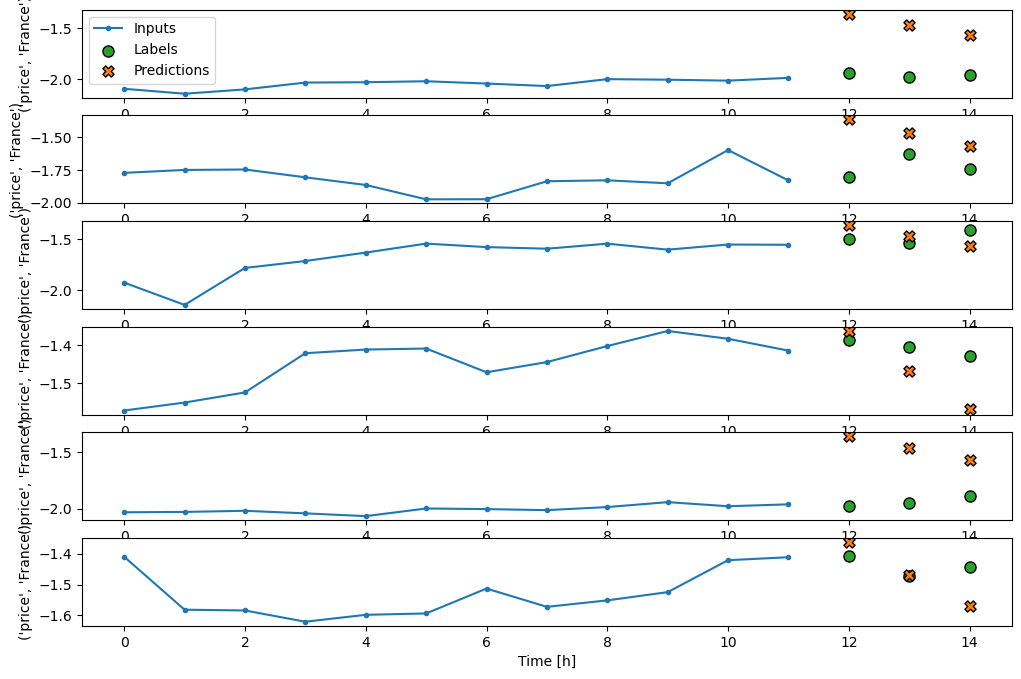

In [45]:
val_performance = {}
performance = {}

val_performance['1'] = m.evaluate(w.val)
# performance['1'] = m.evaluate(w.test)
w.plot(m, plot_col=label_columns[1], max_subplots=6)

In [ ]:
w.example

((<tf.Tensor: shape=(32, 24, 85), dtype=float32, numpy=
  array([[[-0.0846, -1.3429, -0.6165, ...,  9.3225,  7.4433,  6.5417],
          [-0.0511, -1.3371,  0.2574, ...,  9.19  ,  7.4367,  6.5033],
          [-0.0732, -1.3275,  0.2898, ...,  9.0575,  7.43  ,  6.465 ],
          ...,
          [ 0.1491, -1.6419, -0.238 , ...,  7.5933,  8.5567,  7.1867],
          [ 0.2844, -1.6431, -0.3399, ...,  7.6117,  8.7408,  7.3933],
          [ 0.5876, -1.6378, -0.5797, ...,  7.63  ,  8.925 ,  7.6   ]],
  
         [[ 0.2569, -1.3487,  0.0519, ...,  9.455 ,  7.45  ,  6.58  ],
          [-0.0846, -1.3429, -0.6165, ...,  9.3225,  7.4433,  6.5417],
          [-0.0511, -1.3371,  0.2574, ...,  9.19  ,  7.4367,  6.5033],
          ...,
          [ 0.1191, -1.6294, -0.2623, ...,  7.575 ,  8.3725,  6.98  ],
          [ 0.1491, -1.6419, -0.238 , ...,  7.5933,  8.5567,  7.1867],
          [ 0.2844, -1.6431, -0.3399, ...,  7.6117,  8.7408,  7.3933]],
  
         [[-0.2348, -1.5511,  0.2389, ...,  7.7217,  9

In [ ]:
dataset = w.train
# column_indices = w.train_df.columns.get_loc(w.label_columns)
column_indices = [w.train_df.columns.get_loc(idx) for idx in w.label_columns]
dataset.map(lambda x, y: (tf.gather(x, column_indices, axis=2), y))
# w.label_columns

<MapDataset element_spec=(TensorSpec(shape=(None, 24, 5), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10, 5), dtype=tf.float32, name=None))>